In [1]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import warnings

warnings.filterwarnings('ignore')

## Data Processing

In [2]:
data = pd.read_excel('data/mixture/Sensor 1_sensor 2_sensor 3_111_121_112_211_with ratio.xlsx')
data = data.dropna()

ratios = []
for i in data['ratio of A1:A2:A3'].astype('str'):
    splits = i.split()
    ratios.append(splits[-1])

data['ratio of A1:A2:A3'] = ratios
data.iloc[8,0] = '35:49:08'
data.iloc[9,0] = '70:49:16'
data.iloc[10,0] = '70:49:32'
data.iloc[11,0] = '140:49:16'

data.head(2)

,ratio of A1:A2:A3,sensor 1_voltage,sensor 2_voltage,sensor 3_voltage
0,01:02:01,162.0,65.266,-133.15
1,01:04:02,143.0,87.310,155.00


In [3]:
# We shall split the ratios of A1:A2:A3 into 3 separate columns

data[['A1', 'A2', 'A3']] = data['ratio of A1:A2:A3'].str.split(':', expand=True)
data['A1'] = data['A1'].astype('float32')
data['A2'] = data['A2'].astype('float32')
data['A3'] = data['A3'].astype('float32')

data['sum'] = data['A1'] + data['A2'] + data['A3']

data.head(2)

,ratio of A1:A2:A3,sensor 1_voltage,sensor 2_voltage,sensor 3_voltage,A1,A2,A3,sum
0,01:02:01,162.0,65.266,-133.15,1.0,2.0,1.0,4.0
1,01:04:02,143.0,87.310,155.00,1.0,4.0,2.0,7.0


In [4]:
# Scaling the analyte ratios between 0 and 1

data['A1'] = data['A1']/data['sum']
data['A2'] = data['A2']/data['sum']
data['A3'] = data['A3']/data['sum']

# drop the sum and ratio column

data = data.drop(['sum'], axis=1)

data.head(2)

,ratio of A1:A2:A3,sensor 1_voltage,sensor 2_voltage,sensor 3_voltage,A1,A2,A3
0,01:02:01,162.0,65.266,-133.15,0.250000,0.500000,0.250000
1,01:04:02,143.0,87.310,155.00,0.142857,0.571429,0.285714


## Now we have 3 different sensor readings to be predicted - 3 analyte ratios as predictors

In [5]:
X = data[['A1','A2','A3']]
sensor1 = data['sensor 1_voltage']
sensor2 = data['sensor 2_voltage']
sensor3 = data['sensor 3_voltage']

print('Total number of datapoints:', len(X))

Total number of datapoints: 20


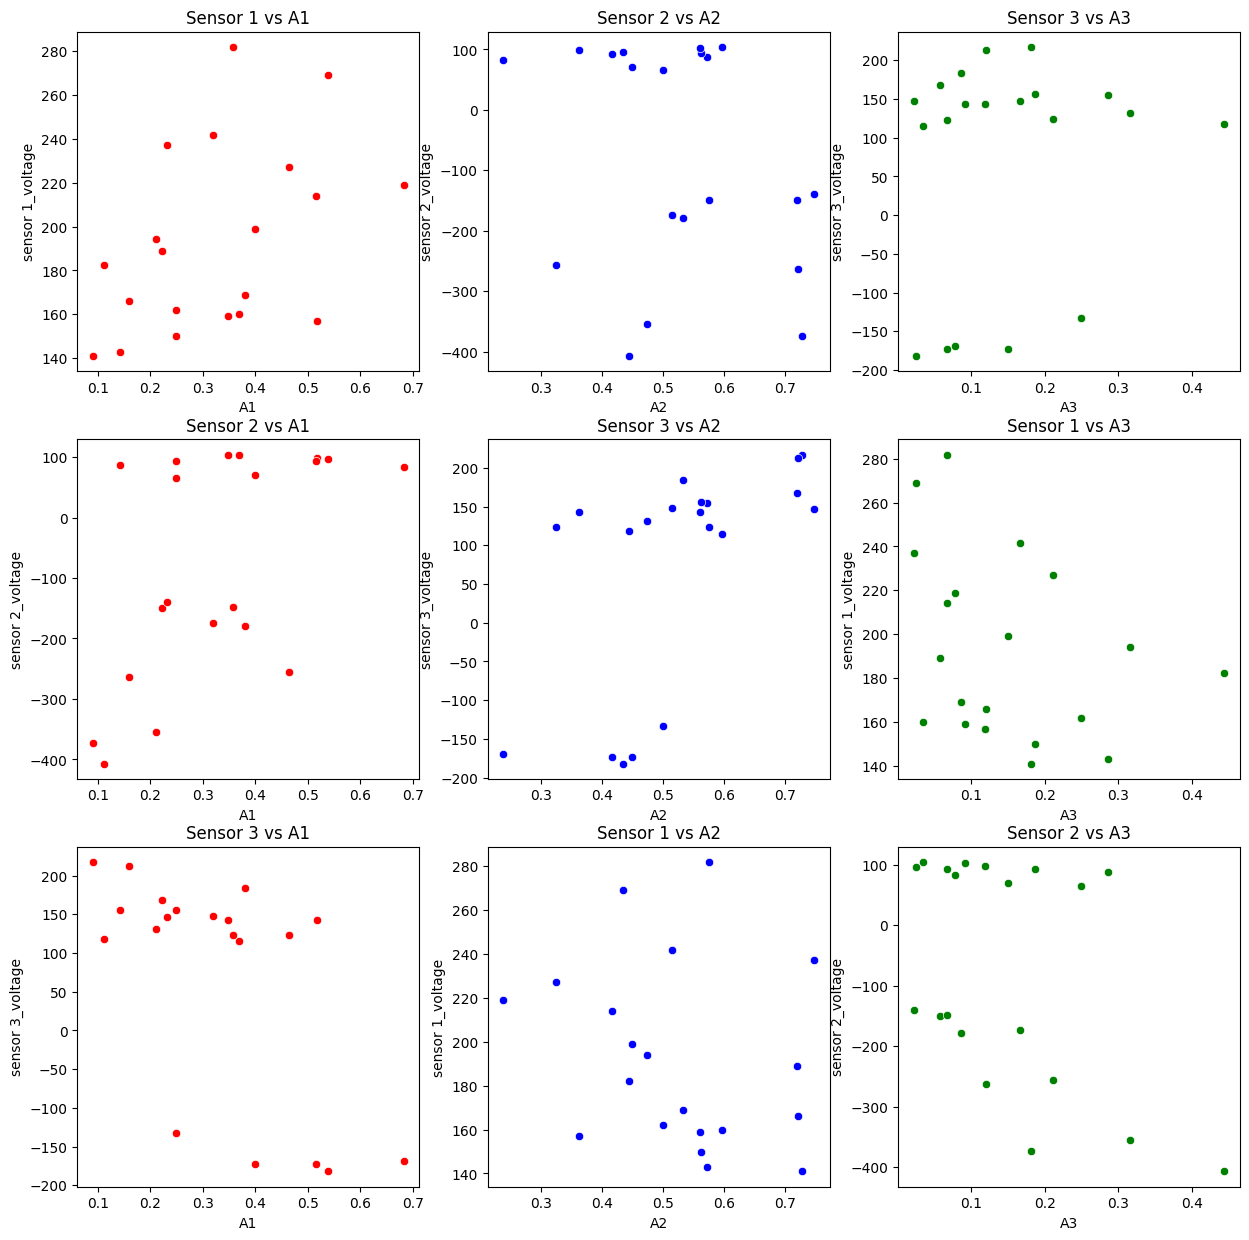

In [6]:
# Let us analyze the trends of Sensor 1, Sensor 2 and Sensor 3 with respect to the analyte ratios.
# For this we shall observe the correlation between the analyte ratios and the sensor voltages.

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
sns.scatterplot(x='A1', y='sensor 1_voltage', data=data, c='r')
plt.title('Sensor 1 vs A1')

plt.subplot(3,3,2)
sns.scatterplot(x='A2', y='sensor 2_voltage', data=data, c='b')
plt.title('Sensor 2 vs A2')

plt.subplot(3,3,3)
sns.scatterplot(x='A3', y='sensor 3_voltage', data=data, c='g')
plt.title('Sensor 3 vs A3')

plt.subplot(3,3,4)
sns.scatterplot(x='A1', y='sensor 2_voltage', data=data, c='r')
plt.title('Sensor 2 vs A1')

plt.subplot(3,3,5)
sns.scatterplot(x='A2', y='sensor 3_voltage', data=data, c='b')
plt.title('Sensor 3 vs A2')

plt.subplot(3,3,6)
sns.scatterplot(x='A3', y='sensor 1_voltage', data=data, c='g')
plt.title('Sensor 1 vs A3')

plt.subplot(3,3,7)
sns.scatterplot(x='A1', y='sensor 3_voltage', data=data, c='r')
plt.title('Sensor 3 vs A1')

plt.subplot(3,3,8)
sns.scatterplot(x='A2', y='sensor 1_voltage', data=data, c='b')
plt.title('Sensor 1 vs A2')

plt.subplot(3,3,9)
sns.scatterplot(x='A3', y='sensor 2_voltage', data=data, c='g')
plt.title('Sensor 2 vs A3')

plt.show()

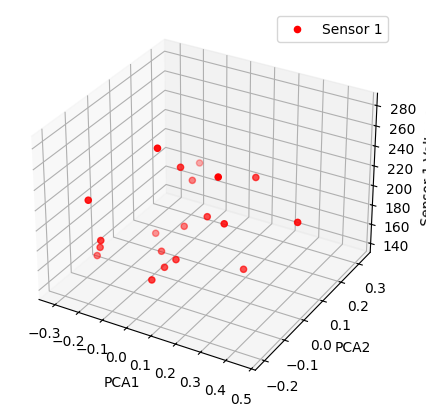

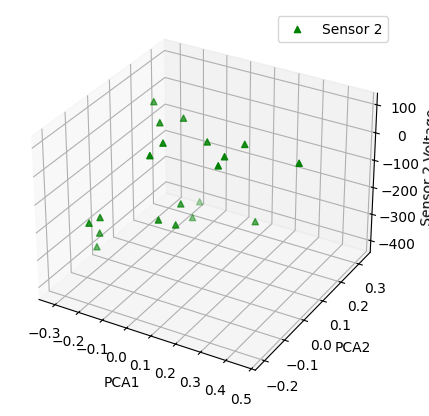

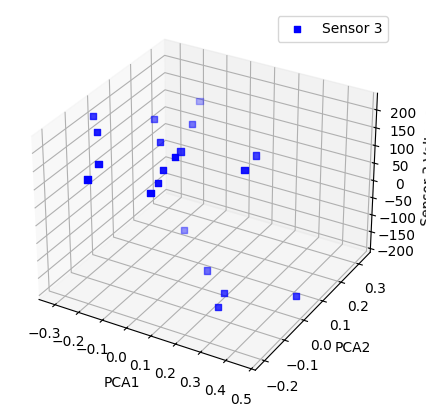

In [7]:
'''We try with the PCA values'''

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca['PCA1'], X_pca['PCA2'], sensor1, c='r', marker='o', label='Sensor 1')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('Sensor 1 Voltage')
ax.legend()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca['PCA1'], X_pca['PCA2'], sensor2, c='g', marker='^', label='Sensor 2')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('Sensor 2 Voltage')
ax.legend()
plt.show()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca['PCA1'], X_pca['PCA2'], sensor3, c='b', marker='s', label='Sensor 3')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('Sensor 3 Voltage')
ax.legend()
plt.show()



## Interpolating for Mixtures

In [8]:
'''We can increase the number of datapoints by using SMOTE '''

Y = data[['A1','A2','A3']]
X = data[['sensor 1_voltage', 'sensor 2_voltage', 'sensor 3_voltage']]


def generate_synthetic_data(X, Y, num_samples=100):

    nbrs = NearestNeighbors(n_neighbors=5).fit(X)
    synthetic_X, synthetic_Y = [], []
    
    for _ in range(num_samples):
        idx = np.random.randint(0, len(X))  
        neighbors = nbrs.kneighbors([X.iloc[idx,:]], return_distance=False)[0]
        chosen_neighbor = np.random.choice(neighbors)

        lam = np.random.uniform()
        new_X = X.iloc[idx,:] * (1 - lam) + X.iloc[chosen_neighbor,:] * lam
        new_Y = Y.iloc[idx] * (1 - lam) + Y.iloc[chosen_neighbor] * lam
        
        synthetic_X.append(new_X)
        synthetic_Y.append(new_Y)
    
    return np.array(synthetic_X), np.array(synthetic_Y)



X_synthetic, Y_synthetic = generate_synthetic_data(X, Y, num_samples=100)
Y_synthetic = pd.DataFrame(Y_synthetic, columns=['A1', 'A2', 'A3'])
X_synthetic = pd.DataFrame(X_synthetic, columns=['sensor 1_voltage', 'sensor 2_voltage', 'sensor 3_voltage'])

In [9]:
X = pd.concat([X, X_synthetic], axis=0).sample(frac=1).reset_index(drop=True)
Y = pd.concat([Y, Y_synthetic], axis=0).sample(frac=1).reset_index(drop=True)

X.head(5)

,sensor 1_voltage,sensor 2_voltage,sensor 3_voltage
0,159.590508,103.118599,118.735579
1,218.953369,83.085220,-169.037305
2,224.742521,79.945058,-176.309753
3,186.454440,72.870044,-148.530556
4,219.000000,82.990000,-169.000000


## Assigning Labels to Mixtures

In [10]:
'''We can increase the number of datapoints by using SMOTE '''

Y = data[['A1','A2','A3']]
X = data[['sensor 1_voltage', 'sensor 2_voltage', 'sensor 3_voltage']]


def generate_synthetic_data(X, Y, num_samples=100):

    nbrs = NearestNeighbors(n_neighbors=5).fit(X)
    synthetic_X, synthetic_Y = [], []
    
    for _ in range(num_samples):
        idx = np.random.randint(0, len(X))  
        neighbors = nbrs.kneighbors([X.iloc[idx,:]], return_distance=False)[0]
        chosen_neighbor = np.random.choice(neighbors)

        lam = np.random.uniform()
        new_X = X.iloc[idx,:] * (1 - lam) + X.iloc[chosen_neighbor,:] * lam
        new_Y = Y.iloc[idx] * (1 - lam) + Y.iloc[chosen_neighbor] * lam
        
        synthetic_X.append(new_X)
        synthetic_Y.append(new_Y)
    
    return np.array(synthetic_X), np.array(synthetic_Y)



X_synthetic, Y_synthetic = generate_synthetic_data(X, Y, num_samples=100)
Y_synthetic = pd.DataFrame(Y_synthetic, columns=['A1', 'A2', 'A3'])
X_synthetic = pd.DataFrame(X_synthetic, columns=['sensor 1_voltage', 'sensor 2_voltage', 'sensor 3_voltage'])

X = pd.concat([X, X_synthetic], axis=0).sample(frac=1).reset_index(drop=True)
Y = pd.concat([Y, Y_synthetic], axis=0).sample(frac=1).reset_index(drop=True)

In [11]:
''' We shall first assign the various analyte ratios to different classes using KMeans clustering '''

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(Y)
Y['class'] = kmeans.labels_

Y_centroid = pd.DataFrame(kmeans.cluster_centers_, columns=['A1', 'A2', 'A3'])
Y_centroid['class'] = range(10)
Y_centroid

,A1,A2,A3,class
0,0.329867,0.601099,0.069034,0
1,0.499297,0.384399,0.116304,1
2,0.201303,0.498790,0.299907,2
3,0.167996,0.721483,0.110521,3
4,0.334527,0.512162,0.153312,4
5,0.640507,0.279660,0.079833,5
6,0.251257,0.546696,0.202047,6
7,0.518818,0.429783,0.051399,7
8,0.110693,0.450295,0.439012,8
9,0.419659,0.386181,0.194160,9


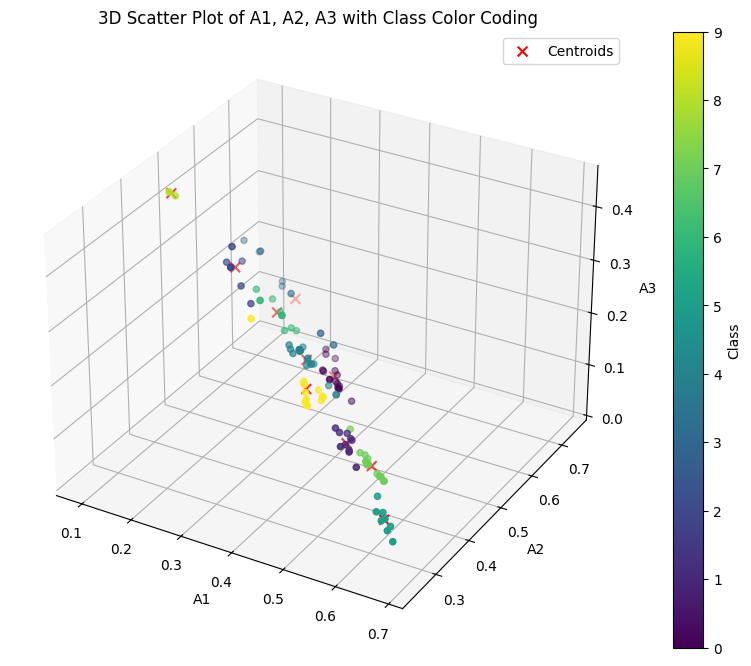

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Y['A1'], Y['A2'], Y['A3'], c=Y['class'], cmap='viridis', marker='o')

ax.set_xlabel('A1')
ax.set_ylabel('A2')
ax.set_zlabel('A3')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Class')

# Plot centroids
ax.scatter(Y_centroid['A1'], Y_centroid['A2'], Y_centroid['A3'], c='red', s=50, marker='x', label='Centroids')
ax.legend()

plt.title('3D Scatter Plot of A1, A2, A3 with Class Color Coding')
plt.show()

In [13]:
Y_labels = Y['class']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_labels, test_size=0.2, random_state=0)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

In [14]:
# FITTING SVMS 

svm = SVC(kernel='sigmoid', C=1, gamma='auto', random_state=0)
svm.fit(X_train, Y_train)

train_pred = svm.predict(X_train)
print('Training Accuracy:', accuracy_score(Y_train, train_pred))

Training Accuracy: 0.1875


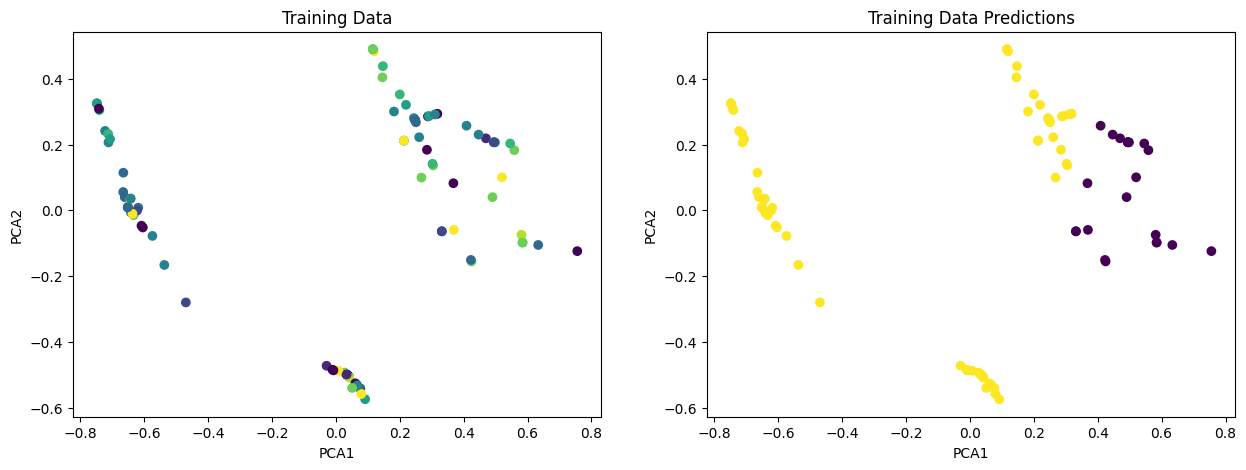

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(X_train_pca[:,0], X_train_pca[:,1], c=Y_train, cmap='viridis', marker='o')
axs[0].set_xlabel('PCA1')
axs[0].set_ylabel('PCA2')
axs[0].set_title('Training Data')

axs[1].scatter(X_train_pca[:,0], X_train_pca[:,1], c=train_pred, cmap='viridis', marker='o')
axs[1].set_xlabel('PCA1')
axs[1].set_ylabel('PCA2')
axs[1].set_title('Training Data Predictions')

plt.show()